In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, DefaultDataCollator
from datasets import load_dataset

from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, precision_score, recall_score

In [2]:
dataset = load_dataset("e1010101/tongue-images-384-segmented-augmented")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels', 'pixel_values'],
        num_rows: 1238
    })
    validation: Dataset({
        features: ['image', 'labels', 'pixel_values'],
        num_rows: 181
    })
    test: Dataset({
        features: ['image', 'labels', 'pixel_values'],
        num_rows: 94
    })
})

In [4]:
# Constants
num_classes = 3
class_names = ['Crack', 'Red-Dots', 'Toothmark']

# Model Development

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-384",
    num_labels=3,
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True,
    id2label={0: 'Crack', 1: 'Red-Dots', 2: 'Toothmark'},
    label2id={'Crack': 0, 'Red-Dots': 1, 'Toothmark': 2}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model = model.to(device)

In [8]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probabilities > 0.5).astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## Training

In [9]:
training_args = TrainingArguments(
    output_dir="./checkpoints/vit-384/segmented-augmented/",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True
)

c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=DefaultDataCollator(),
    compute_metrics=compute_metrics,
)

In [11]:
trainer.train()

  0%|          | 0/390 [00:00<?, ?it/s]

c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\transformers\models\vit\modeling_vit.py:252: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


{'loss': 0.6677, 'grad_norm': 2.793767213821411, 'learning_rate': 1.9487179487179488e-05, 'epoch': 0.13}
{'loss': 0.6278, 'grad_norm': 1.7174216508865356, 'learning_rate': 1.8974358974358975e-05, 'epoch': 0.26}
{'loss': 0.6828, 'grad_norm': 2.5926318168640137, 'learning_rate': 1.8461538461538465e-05, 'epoch': 0.38}
{'loss': 0.6465, 'grad_norm': 2.677354097366333, 'learning_rate': 1.794871794871795e-05, 'epoch': 0.51}
{'loss': 0.626, 'grad_norm': 3.0302541255950928, 'learning_rate': 1.7435897435897438e-05, 'epoch': 0.64}
{'loss': 0.6063, 'grad_norm': 1.8318921327590942, 'learning_rate': 1.6923076923076924e-05, 'epoch': 0.77}
{'loss': 0.5617, 'grad_norm': 2.326206684112549, 'learning_rate': 1.641025641025641e-05, 'epoch': 0.9}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.5225109457969666, 'eval_precision': 0.6884057971014492, 'eval_recall': 0.946843853820598, 'eval_f1': 0.7972027972027972, 'eval_runtime': 30.3241, 'eval_samples_per_second': 5.969, 'eval_steps_per_second': 0.396, 'epoch': 1.0}
{'loss': 0.5754, 'grad_norm': 2.8979196548461914, 'learning_rate': 1.5897435897435897e-05, 'epoch': 1.03}
{'loss': 0.5442, 'grad_norm': 2.2549357414245605, 'learning_rate': 1.5384615384615387e-05, 'epoch': 1.15}
{'loss': 0.5311, 'grad_norm': 2.1984994411468506, 'learning_rate': 1.4871794871794874e-05, 'epoch': 1.28}
{'loss': 0.4996, 'grad_norm': 1.7652076482772827, 'learning_rate': 1.435897435897436e-05, 'epoch': 1.41}
{'loss': 0.4967, 'grad_norm': 2.7193803787231445, 'learning_rate': 1.3846153846153847e-05, 'epoch': 1.54}
{'loss': 0.4956, 'grad_norm': 2.022693395614624, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.67}
{'loss': 0.495, 'grad_norm': 2.3356666564941406, 'learning_rate': 1.2820512820512823e-05, 'epoch': 1.79}
{'loss': 0.4692, 'g

  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.4488813281059265, 'eval_precision': 0.7528089887640449, 'eval_recall': 0.8903654485049833, 'eval_f1': 0.8158295281582952, 'eval_runtime': 30.2194, 'eval_samples_per_second': 5.99, 'eval_steps_per_second': 0.397, 'epoch': 2.0}
{'loss': 0.4348, 'grad_norm': 1.525181770324707, 'learning_rate': 1.1794871794871796e-05, 'epoch': 2.05}
{'loss': 0.3995, 'grad_norm': 2.142108917236328, 'learning_rate': 1.1282051282051283e-05, 'epoch': 2.18}
{'loss': 0.4438, 'grad_norm': 2.3503339290618896, 'learning_rate': 1.076923076923077e-05, 'epoch': 2.31}
{'loss': 0.4063, 'grad_norm': 1.9733270406723022, 'learning_rate': 1.0256410256410256e-05, 'epoch': 2.44}
{'loss': 0.3877, 'grad_norm': 1.9901313781738281, 'learning_rate': 9.743589743589744e-06, 'epoch': 2.56}
{'loss': 0.4253, 'grad_norm': 2.2168326377868652, 'learning_rate': 9.230769230769232e-06, 'epoch': 2.69}
{'loss': 0.4051, 'grad_norm': 2.3742451667785645, 'learning_rate': 8.717948717948719e-06, 'epoch': 2.82}
{'loss': 0.3834, 'grad

  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.4223960041999817, 'eval_precision': 0.7486631016042781, 'eval_recall': 0.9302325581395349, 'eval_f1': 0.8296296296296296, 'eval_runtime': 29.6108, 'eval_samples_per_second': 6.113, 'eval_steps_per_second': 0.405, 'epoch': 3.0}
{'loss': 0.3465, 'grad_norm': 1.882493019104004, 'learning_rate': 7.692307692307694e-06, 'epoch': 3.08}
{'loss': 0.3388, 'grad_norm': 1.422154188156128, 'learning_rate': 7.17948717948718e-06, 'epoch': 3.21}
{'loss': 0.3365, 'grad_norm': 2.075251579284668, 'learning_rate': 6.666666666666667e-06, 'epoch': 3.33}
{'loss': 0.2966, 'grad_norm': 1.977218747138977, 'learning_rate': 6.153846153846155e-06, 'epoch': 3.46}
{'loss': 0.3469, 'grad_norm': 1.9019999504089355, 'learning_rate': 5.641025641025641e-06, 'epoch': 3.59}
{'loss': 0.3468, 'grad_norm': 2.208294153213501, 'learning_rate': 5.128205128205128e-06, 'epoch': 3.72}
{'loss': 0.3056, 'grad_norm': 1.7686361074447632, 'learning_rate': 4.615384615384616e-06, 'epoch': 3.85}
{'loss': 0.3134, 'grad_norm'

  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.39966580271720886, 'eval_precision': 0.7913043478260869, 'eval_recall': 0.9069767441860465, 'eval_f1': 0.8452012383900929, 'eval_runtime': 30.0688, 'eval_samples_per_second': 6.02, 'eval_steps_per_second': 0.399, 'epoch': 4.0}
{'loss': 0.3133, 'grad_norm': 1.9057930707931519, 'learning_rate': 3.58974358974359e-06, 'epoch': 4.1}
{'loss': 0.2581, 'grad_norm': 2.0738813877105713, 'learning_rate': 3.0769230769230774e-06, 'epoch': 4.23}
{'loss': 0.2668, 'grad_norm': 1.7253777980804443, 'learning_rate': 2.564102564102564e-06, 'epoch': 4.36}
{'loss': 0.2798, 'grad_norm': 2.0911080837249756, 'learning_rate': 2.0512820512820513e-06, 'epoch': 4.49}
{'loss': 0.2837, 'grad_norm': 2.1286513805389404, 'learning_rate': 1.5384615384615387e-06, 'epoch': 4.62}
{'loss': 0.2851, 'grad_norm': 2.2064950466156006, 'learning_rate': 1.0256410256410257e-06, 'epoch': 4.74}
{'loss': 0.2719, 'grad_norm': 1.8116068840026855, 'learning_rate': 5.128205128205128e-07, 'epoch': 4.87}
{'loss': 0.2882, 'gr

  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.39550352096557617, 'eval_precision': 0.7994186046511628, 'eval_recall': 0.9136212624584718, 'eval_f1': 0.8527131782945736, 'eval_runtime': 30.1354, 'eval_samples_per_second': 6.006, 'eval_steps_per_second': 0.398, 'epoch': 5.0}
{'train_runtime': 1825.9778, 'train_samples_per_second': 3.39, 'train_steps_per_second': 0.214, 'train_loss': 0.42794270515441896, 'epoch': 5.0}


TrainOutput(global_step=390, training_loss=0.42794270515441896, metrics={'train_runtime': 1825.9778, 'train_samples_per_second': 3.39, 'train_steps_per_second': 0.214, 'total_flos': 1.4144657980184986e+18, 'train_loss': 0.42794270515441896, 'epoch': 5.0})

## Validation

In [12]:
val_results = trainer.predict(dataset["validation"])

  0%|          | 0/12 [00:00<?, ?it/s]

In [13]:
val_logits = val_results.predictions
val_labels = val_results.label_ids

val_probabilities = torch.sigmoid(torch.tensor(val_logits)).numpy()

val_threshold = 0.5
val_preds = (val_probabilities > val_threshold).astype(int)

## Visualizations

### Positive/Negative Distributions

For the positive distributions, we expect the predicted probabilities to be concentrated near 1 (or 100%). This means the model is confident in its positive predictions. Likewise, for the negative distributions, the predicted probabilities should be concentrated near 0. This means that the model confidently identifies negatives.

In [15]:
df = pd.DataFrame(val_probabilities, columns=[f'prob_{cls}' for cls in class_names])
for idx, cls in enumerate(class_names):
    df[f'true_{cls}'] = val_labels[:, idx]

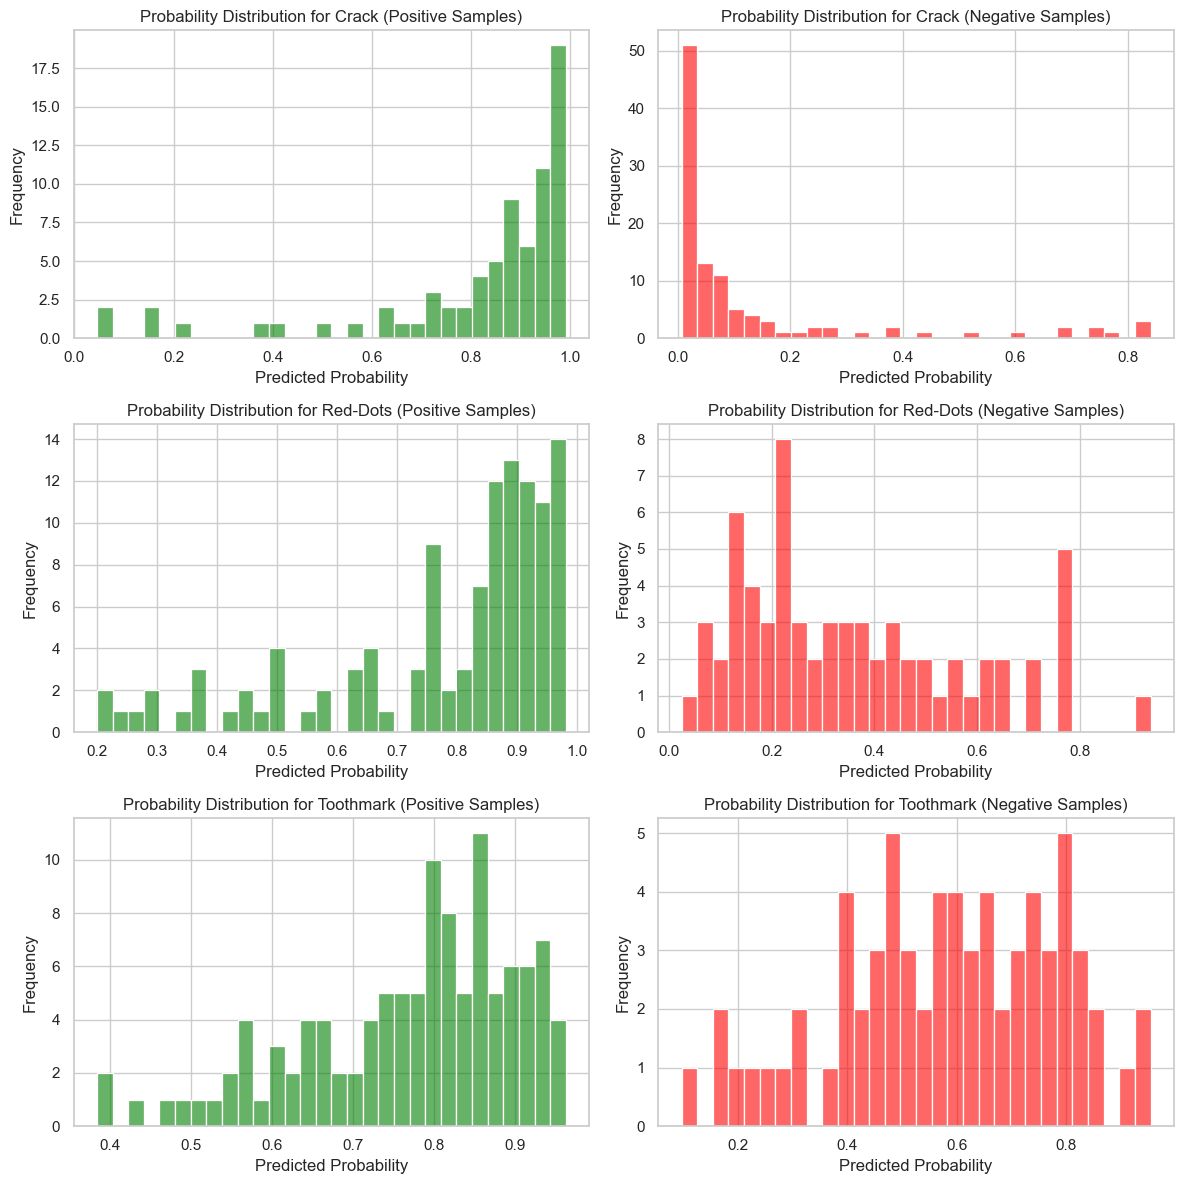

In [16]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(num_classes, 2, figsize=(12, 4 * num_classes))

for i, cls in enumerate(class_names):
    # Positive samples
    pos_probs = df[df[f'true_{cls}'] == 1][f'prob_{cls}']
    
    # Negative samples
    neg_probs = df[df[f'true_{cls}'] == 0][f'prob_{cls}']
    
    sns.histplot(pos_probs, bins=30, color='green', alpha=0.6, kde=False, ax=axes[i, 0])
    axes[i, 0].set_title(f'Probability Distribution for {cls} (Positive Samples)')
    axes[i, 0].set_xlabel('Predicted Probability')
    axes[i, 0].set_ylabel('Frequency')
    
    sns.histplot(neg_probs, bins=30, color='red', alpha=0.6, kde=False, ax=axes[i, 1])
    axes[i, 1].set_title(f'Probability Distribution for {cls} (Negative Samples)')
    axes[i, 1].set_xlabel('Predicted Probability')
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Combined Distributions

Visually, we want minimal overlap between the positive and negative probability distributions, as this indicates that the model effectively distinguishes between each class. For each class, we should observe two distinct peaks—one near 0 (negatives) and one near 1 (positives).

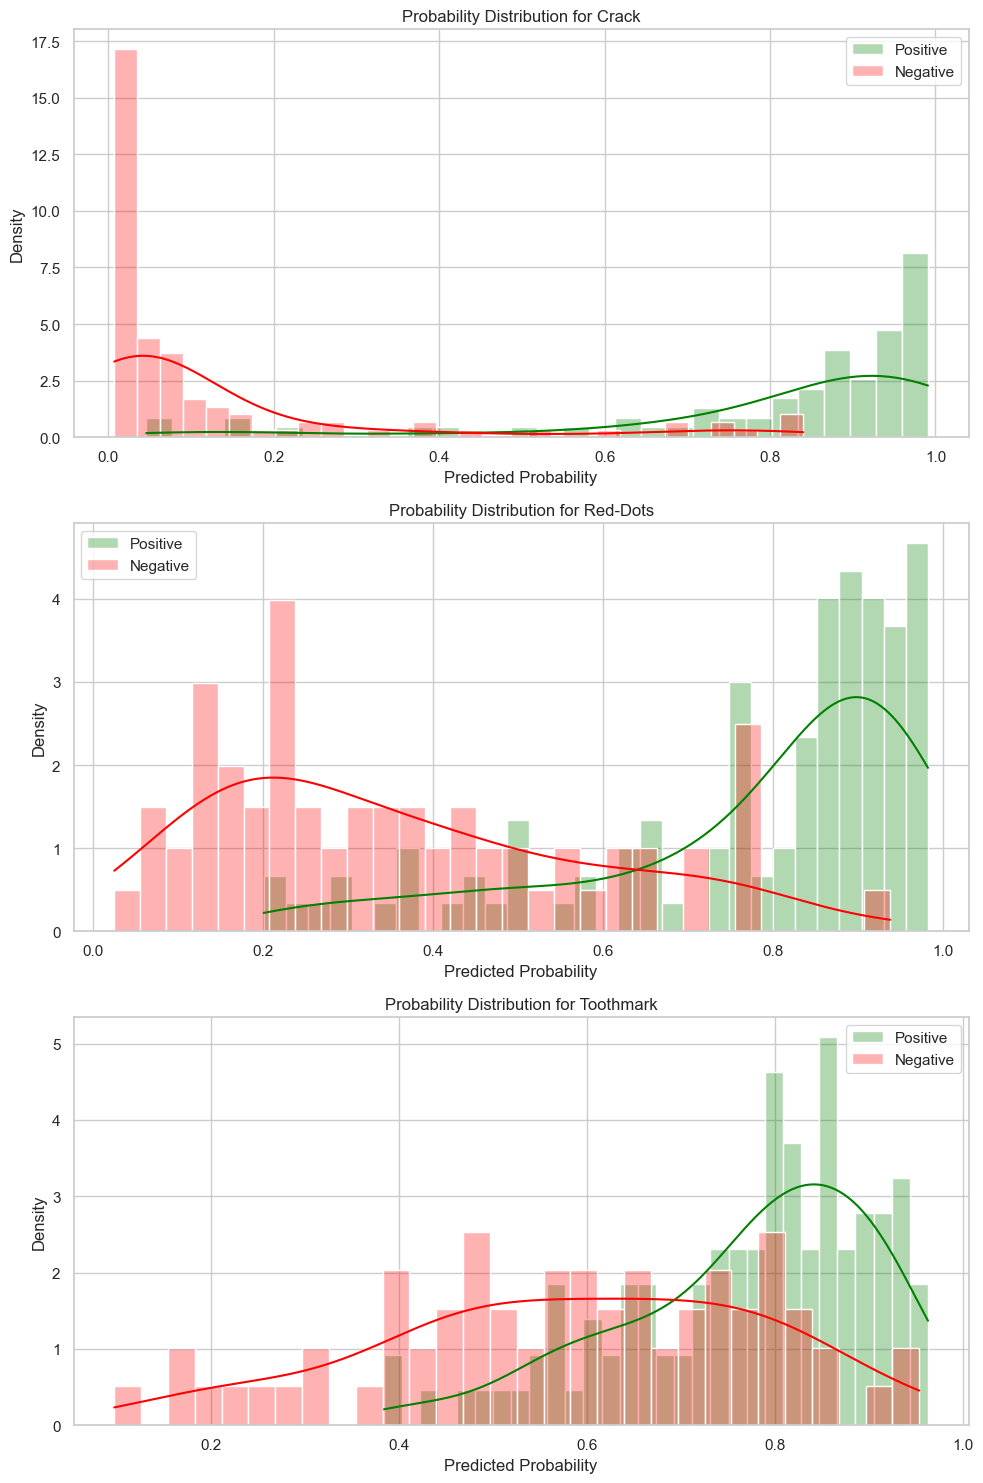

In [17]:
fig, axes = plt.subplots(num_classes, 1, figsize=(10, 5 * num_classes))

for i, cls in enumerate(class_names):
    plt.subplot(num_classes, 1, i+1)
    
    # Positive samples
    pos_probs = df[df[f'true_{cls}'] == 1][f'prob_{cls}']
    
    # Negative samples
    neg_probs = df[df[f'true_{cls}'] == 0][f'prob_{cls}']
    
    sns.histplot(pos_probs, bins=30, color='green', alpha=0.3, kde=True, label='Positive', stat="density")
    sns.histplot(neg_probs, bins=30, color='red', alpha=0.3, kde=True, label='Negative', stat="density")
    
    plt.title(f'Probability Distribution for {cls}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

### Model Coverage

We find two thresholds, A and B. Threshold A is the minimum value (between 0 and 1) such that all model predictions above A have a precision of at least 0.9, while threshold B is the maximum value (between 0 and 1) such that all model predictions below B have a specificity of at least 0.9. The percentage of results above/below these thresholds can be said to be "explained" by the model, leaving only the "uncertain" predictions in between to be assessed by human evaluators.

In [18]:
df = pd.DataFrame(val_probabilities, columns=[f'prob_{cls}' for cls in class_names])
for idx, cls in enumerate(class_names):
    df[f'true_{cls}'] = val_labels[:, idx]

In [19]:
def prec_line(thres_list, true_labels, pred_probs):
    prec_list = []
    for thres in thres_list:
        pred_pos = pred_probs > thres
        total_pred_pos = np.sum(pred_pos)
        
        if total_pred_pos == 0:
            precision = -0.01
        else:
            TP = np.sum((true_labels == 1) & pred_pos)
            FP = total_pred_pos - TP
            precision = TP / (TP + FP)

        prec_list.append(precision)
        
    return thres_list, prec_list

In [20]:
def spec_line(thres_list, true_labels, pred_probs):
    spec_list = []
    for thres in thres_list:
        pred_neg = pred_probs < thres
        total_pred_neg = np.sum(pred_neg)
        
        if total_pred_neg == 0:
            specificity = -0.01
        else:    
            TN = np.sum((true_labels == 0) & pred_neg)
            FN = total_pred_neg - TN
            specificity = TN / (TN + FN)

        spec_list.append(specificity)
        
    return thres_list, spec_list

(0.5, 1.0)

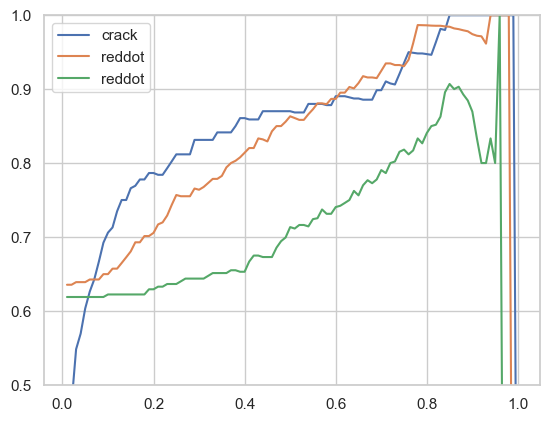

In [21]:
thres_list = np.arange(1, 0, -0.01)
true_labels_crack = df['true_Crack'].values
pred_probs_crack = df['prob_Crack'].values

true_labels_reddot = df['true_Red-Dots'].values
pred_probs_reddot = df['prob_Red-Dots'].values

true_labels_tooth = df['true_Toothmark'].values
pred_probs_tooth = df['prob_Toothmark'].values

_, prec_crack = prec_line(thres_list, true_labels_crack, pred_probs_crack)
_, prec_reddot = prec_line(thres_list, true_labels_reddot, pred_probs_reddot)
_, prec_tooth = prec_line(thres_list, true_labels_tooth, pred_probs_tooth)

plt.plot(thres_list, prec_crack, label='crack')
plt.plot(thres_list, prec_reddot, label='reddot')
plt.plot(thres_list, prec_tooth, label='reddot')
plt.legend()
plt.ylim(0.5, 1)

(0.5, 1.0)

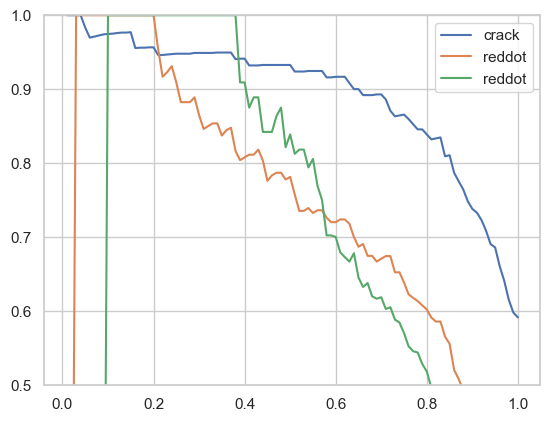

In [22]:
thres_list = np.arange(1, 0, -0.01)
true_labels_crack = df['true_Crack'].values
pred_probs_crack = df['prob_Crack'].values

true_labels_reddot = df['true_Red-Dots'].values
pred_probs_reddot = df['prob_Red-Dots'].values

true_labels_tooth = df['true_Toothmark'].values
pred_probs_tooth = df['prob_Toothmark'].values

_, spec_crack = spec_line(thres_list, true_labels_crack, pred_probs_crack)
_, spec_reddot = spec_line(thres_list, true_labels_reddot, pred_probs_reddot)
_, spec_tooth = spec_line(thres_list, true_labels_tooth, pred_probs_tooth)

plt.plot(thres_list, spec_crack, label='crack')
plt.plot(thres_list, spec_reddot, label='reddot')
plt.plot(thres_list, spec_tooth, label='reddot')
plt.legend()
plt.ylim(0.5, 1)

In [23]:
A_thresholds = {}
B_thresholds = {}

In [24]:
tmp = pd.DataFrame({'thres': thres_list, 'crack': prec_crack, 'reddot': prec_reddot, 'tooth': prec_tooth})
A_thresholds['Crack'] = tmp[tmp['crack']>=0.9]['thres'].min()
A_thresholds['Red-Dots'] = tmp[tmp['reddot']>=0.9]['thres'].min()
A_thresholds['Toothmark'] = tmp[tmp['tooth']>=0.9]['thres'].min()

In [25]:
tmp = pd.DataFrame({'thres': thres_list, 'crack': spec_crack, 'reddot': spec_reddot, 'tooth': spec_tooth})
B_thresholds['Crack'] = tmp[tmp['crack']>=0.9]['thres'].max()
B_thresholds['Red-Dots'] = tmp[tmp['reddot']>=0.9]['thres'].max()
B_thresholds['Toothmark'] = tmp[tmp['tooth']>=0.9]['thres'].max()

In [26]:
print(A_thresholds)
print(B_thresholds)

{'Crack': 0.7099999999999997, 'Red-Dots': 0.6299999999999997, 'Toothmark': 0.8499999999999999}
{'Crack': 0.6499999999999997, 'Red-Dots': 0.24999999999999933, 'Toothmark': 0.39999999999999947}


In [27]:
for i, class_name in enumerate(class_names):
    threshold = A_thresholds[class_name]
    above_threshold_percentage = np.sum(val_probabilities[:, i] > threshold) / len(val_probabilities[:, i]) * 100
    print(f"Percentage of predictions above threshold A for {class_name}: {above_threshold_percentage:.2f}%")

Percentage of predictions above threshold A for Crack: 37.02%
Percentage of predictions above threshold A for Red-Dots: 56.91%
Percentage of predictions above threshold A for Toothmark: 23.76%


In [28]:
for i, class_name in enumerate(class_names):
    threshold = B_thresholds[class_name]
    below_threshold_percentage = np.sum(val_probabilities[:, i] < threshold) / len(val_probabilities[:, i]) * 100
    print(f"Percentage of predictions below threshold B for {class_name}: {below_threshold_percentage:.2f}%")

Percentage of predictions below threshold B for Crack: 60.77%
Percentage of predictions below threshold B for Red-Dots: 18.23%
Percentage of predictions below threshold B for Toothmark: 6.08%


### Optimal Thresholds

By adjusting the threshold, we can balance precision (the proportion of true positives among all positive predictions) and recall (the proportion of true positives among all actual positives). In datasets with class imbalance (such as ours), adjusting the threshold can help the model better detect the minority class.

In [29]:
# Find optimal thresholds based on validation results
thresholds = np.arange(0.0, 1.01, 0.01)

optimal_thresholds = {}

for i, class_name in enumerate(class_names):
    best_threshold = 0.5
    best_f1 = 0.0
    
    for threshold in thresholds:
        preds = (val_probabilities[:, i] > threshold).astype(int)
        
        current_f1 = f1_score(val_labels[:, i], preds)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
    
    optimal_thresholds[class_name] = best_threshold
    print(f"Optimal threshold for '{class_name}': {best_threshold} with F1-score: {best_f1:.4f}")

# Testing

In [31]:
test_results = trainer.predict(dataset["test"])

  0%|          | 0/6 [00:00<?, ?it/s]

In [32]:
test_logits = test_results.predictions
test_labels = test_results.label_ids

test_probabilities = torch.sigmoid(torch.tensor(test_logits)).numpy()

test_preds = np.zeros_like(test_probabilities, dtype=int)
for i, class_name in enumerate(class_names):
    test_preds[:, i] = (test_probabilities[:, i] > optimal_thresholds[class_name]).astype(int)

# Evaluation

## Accuracy

In [33]:
def calculate_class_accuracies(test_labels, test_preds, class_names):
    """
    Calculate the accuracy for each class in multi-label classification.
    
    Args:
        test_labels (numpy.ndarray): True labels for the test images.
        test_preds (numpy.ndarray): Predicted labels for the test images.
        class_names (list): List of class names.
    
    Returns:
        dict: A dictionary with class names as keys and their accuracies as values.
    """
    class_accuracies = {}
    for i, class_name in enumerate(class_names):
        correct_predictions = test_labels[:, i] == test_preds[:, i]
        accuracy = np.mean(correct_predictions)
        class_accuracies[class_name] = accuracy
    
    return class_accuracies

In [34]:
# Calculate class accuracies
class_accuracies = calculate_class_accuracies(test_labels, test_preds, class_names)

# Print accuracies for each class
print("Accuracy for each class:")
for class_name, accuracy in class_accuracies.items():
    print(f"{class_name}: {accuracy:.4f}")

# Calculate and print overall accuracy
overall_accuracy = np.mean(list(class_accuracies.values()))
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

Accuracy for each class:
Crack: 0.9681
Red-Dots: 0.7660
Toothmark: 0.7766

Overall Accuracy: 0.8369


## Classification Report

In [35]:
report = classification_report(test_labels, test_preds, target_names=class_names, zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       Crack       0.94      1.00      0.97        48
    Red-Dots       0.80      0.83      0.81        58
   Toothmark       0.81      0.90      0.85        68

   micro avg       0.84      0.90      0.87       174
   macro avg       0.85      0.91      0.88       174
weighted avg       0.84      0.90      0.87       174
 samples avg       0.77      0.82      0.78       174



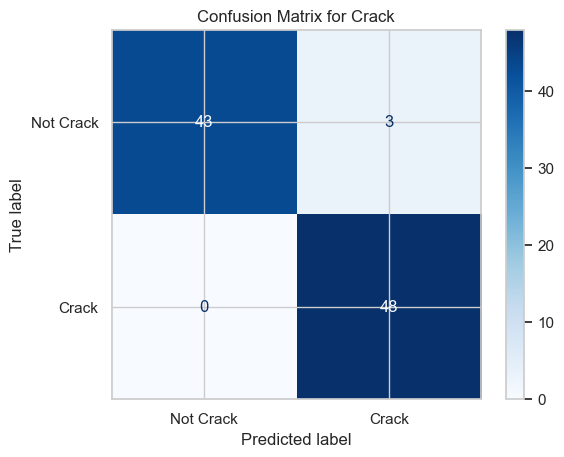

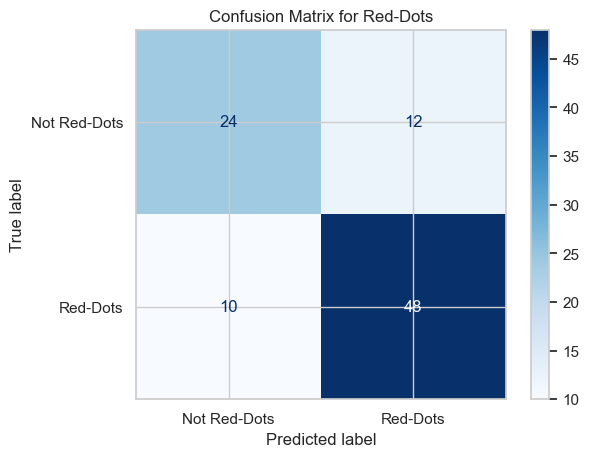

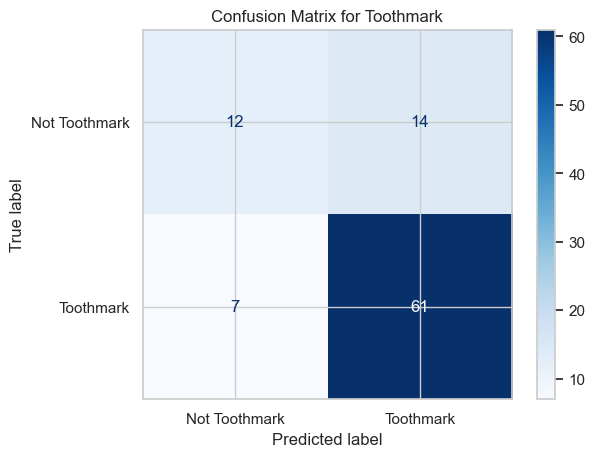

In [36]:
def plot_confusion_matrix_for_class(y_true, y_pred, class_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not ' + class_name, class_name])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {class_name}')
    plt.show()

for idx, class_name in enumerate(class_names):
    y_true = test_labels[:, idx]
    y_pred_class = test_preds[:, idx]
    plot_confusion_matrix_for_class(y_true, y_pred_class, class_name)

In [37]:
f1_micro = f1_score(test_labels, test_preds, average='micro')
f1_macro = f1_score(test_labels, test_preds, average='macro')

print(f"Micro F1-score: {f1_micro:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")

Micro F1-score: 0.8722
Macro F1-score: 0.8788


## Precision/Specificity

In [38]:
def get_precision_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 
    return precision, specificity

# Calculate precision and specificity for each class
for idx, class_name in enumerate(class_names):
    y_true = test_labels[:, idx]
    y_pred_class = test_preds[:, idx]
    precision, specificity = get_precision_specificity(y_true, y_pred_class)
    print(f"Class: {class_name}, Precision: {precision:.4f}, Specificity: {specificity:.4f}")


Class: Crack, Precision: 0.9412, Specificity: 0.9348
Class: Red-Dots, Precision: 0.8000, Specificity: 0.6667
Class: Toothmark, Precision: 0.8133, Specificity: 0.4615


## ROC AUC

In [39]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

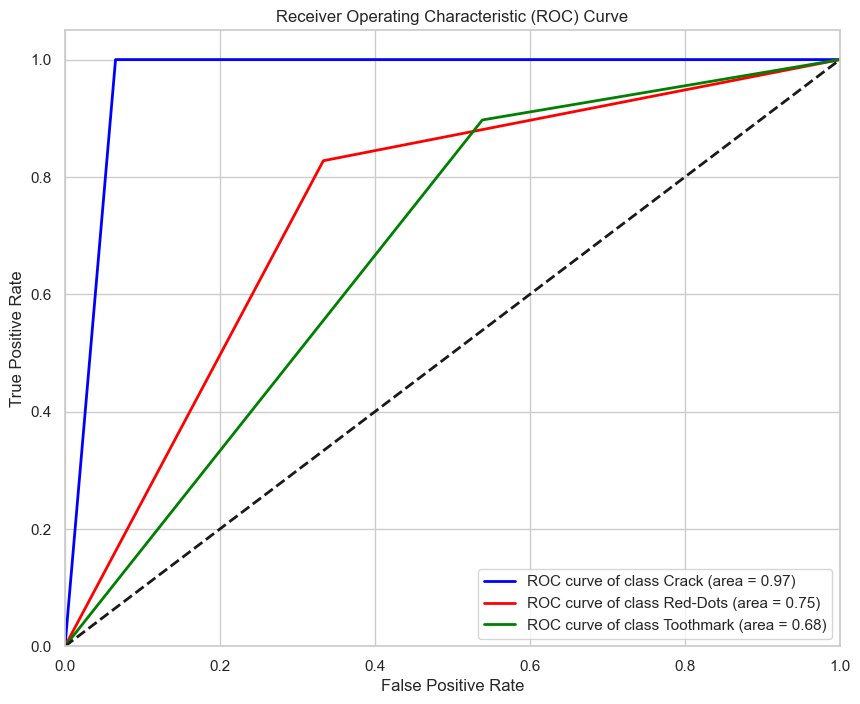

In [40]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i, color, class_name in zip(range(num_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Precison-Recall AUC

In [41]:
precision = {}
recall = {}
average_precision = {}

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_labels[:, i], test_preds[:, i])
    average_precision[i] = average_precision_score(test_labels[:, i], test_preds[:, i])

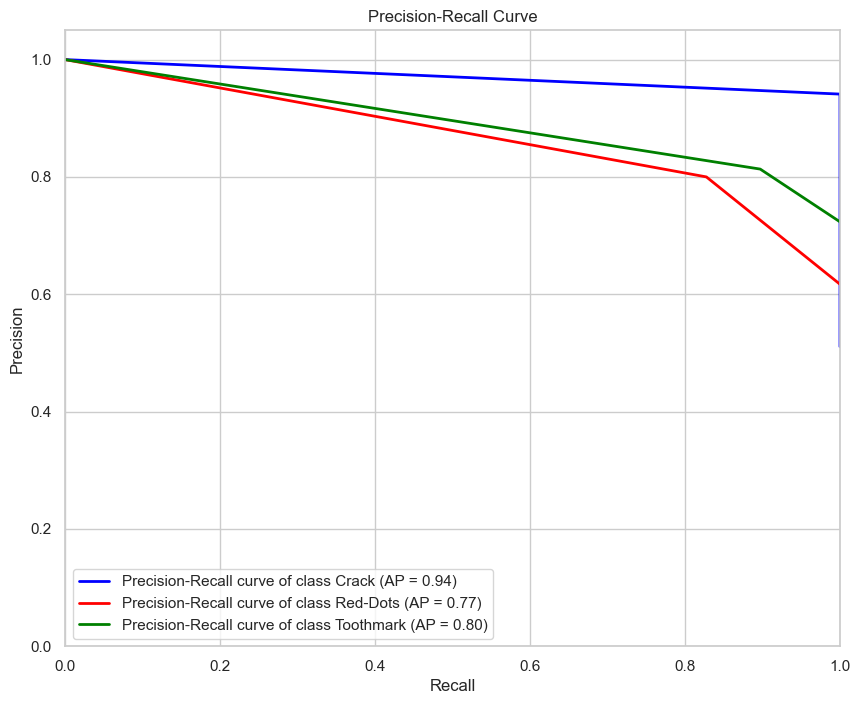

In [42]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']

for i, color, class_name in zip(range(num_classes), colors, class_names):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall curve of class {class_name} '
                   f'(AP = {average_precision[i]:0.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

## Number of Uncertain Predictions

In [43]:
### Number of Uncertain Predictions

uncertainty_threshold = 0.05  # Define your uncertainty threshold (e.g., 0.05 for predictions within +/- 5% of 0.5)

uncertain_counts = {}

for i, class_name in enumerate(class_names):
    uncertain_count = np.sum((test_probabilities[:, i] >= (0.5 - uncertainty_threshold)) & (test_probabilities[:, i] <= (0.5 + uncertainty_threshold)))
    uncertain_counts[class_name] = uncertain_count
    print(f"Number of uncertain predictions for {class_name}: {uncertain_count}")

total_uncertain = sum(uncertain_counts.values())
print(f"\nTotal number of uncertain predictions (across all classes): {total_uncertain}")


Number of uncertain predictions for Crack: 3
Number of uncertain predictions for Red-Dots: 3
Number of uncertain predictions for Toothmark: 8

Total number of uncertain predictions (across all classes): 14


## Incorrect Predictions

In [44]:
def visualize_incorrect_predictions(test_images, test_labels, test_preds, class_names, num_images=5):
    """
    Visualizes incorrectly predicted images from the testing set.

    Args:
        test_images (list): List of test images.
        test_labels (numpy.ndarray): True labels for the test images.
        test_preds (numpy.ndarray): Predicted labels for the test images.
        class_names (list): List of class names.
        num_images (int, optional): Number of images to visualize. Defaults to 5.
    """
    incorrect_indices = np.where(np.any(test_labels != test_preds, axis=1))[0]
    num_incorrect = len(incorrect_indices)

    if num_incorrect == 0:
        print("No incorrect predictions found.")
        return

    num_images = min(num_images, num_incorrect)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        idx = incorrect_indices[i]
        image = test_images[idx]
        true_labels = test_labels[idx]
        pred_labels = test_preds[idx]

        axes[i].imshow(image)
        axes[i].axis('off')

        true_label_names = [class_names[j] for j in range(len(class_names)) if true_labels[j] == 1]
        pred_label_names = [class_names[j] for j in range(len(class_names)) if pred_labels[j] == 1]

        title = f"True: {', '.join(true_label_names)}\nPred: {', '.join(pred_label_names)}"
        axes[i].set_title(title)

    plt.tight_layout()
    plt.show()

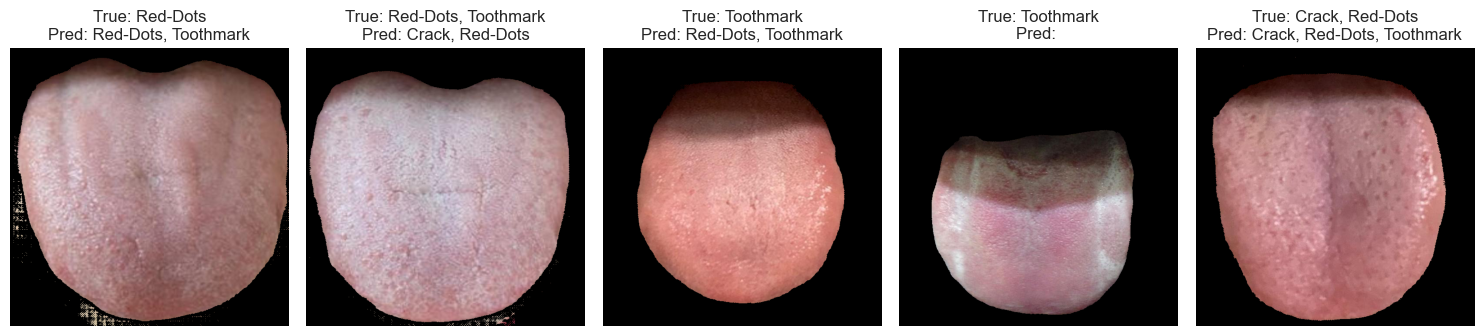

In [45]:
visualize_incorrect_predictions(dataset['test']['image'], test_labels, test_preds, class_names)

In [46]:
def visualize_class_examples(test_images, test_labels, test_preds, class_names):
    """
    Visualizes three random examples for each class: one correctly predicted,
    one false negative, and one false positive.

    Args:
        test_images (list): List of test images.
        test_labels (numpy.ndarray): True labels for the test images.
        test_preds (numpy.ndarray): Predicted labels for the test images.
        class_names (list): List of class names.
    """
    fig, axes = plt.subplots(len(class_names), 3, figsize=(15, 5 * len(class_names)))

    for class_idx, class_name in enumerate(class_names):
        true_positives = np.where((test_labels[:, class_idx] == 1) & (test_preds[:, class_idx] == 1))[0]
        false_negatives = np.where((test_labels[:, class_idx] == 1) & (test_preds[:, class_idx] == 0))[0]
        false_positives = np.where((test_labels[:, class_idx] == 0) & (test_preds[:, class_idx] == 1))[0]

        examples = []
        titles = ['Correct Prediction', 'False Negative', 'False Positive']

        for idx_list in [true_positives, false_negatives, false_positives]:
            if len(idx_list) > 0:
                examples.append(np.random.choice(idx_list))
            else:
                examples.append(None)

        for i, (example_idx, title) in enumerate(zip(examples, titles)):
            if example_idx is not None:
                image = test_images[example_idx]
                axes[class_idx, i].imshow(image)
                axes[class_idx, i].axis('off')
                axes[class_idx, i].set_title(f"{class_name}\n{title}")
            else:
                axes[class_idx, i].axis('off')
                axes[class_idx, i].set_title(f"{class_name}\n{title}\n(No example found)")

    plt.tight_layout()
    plt.show()

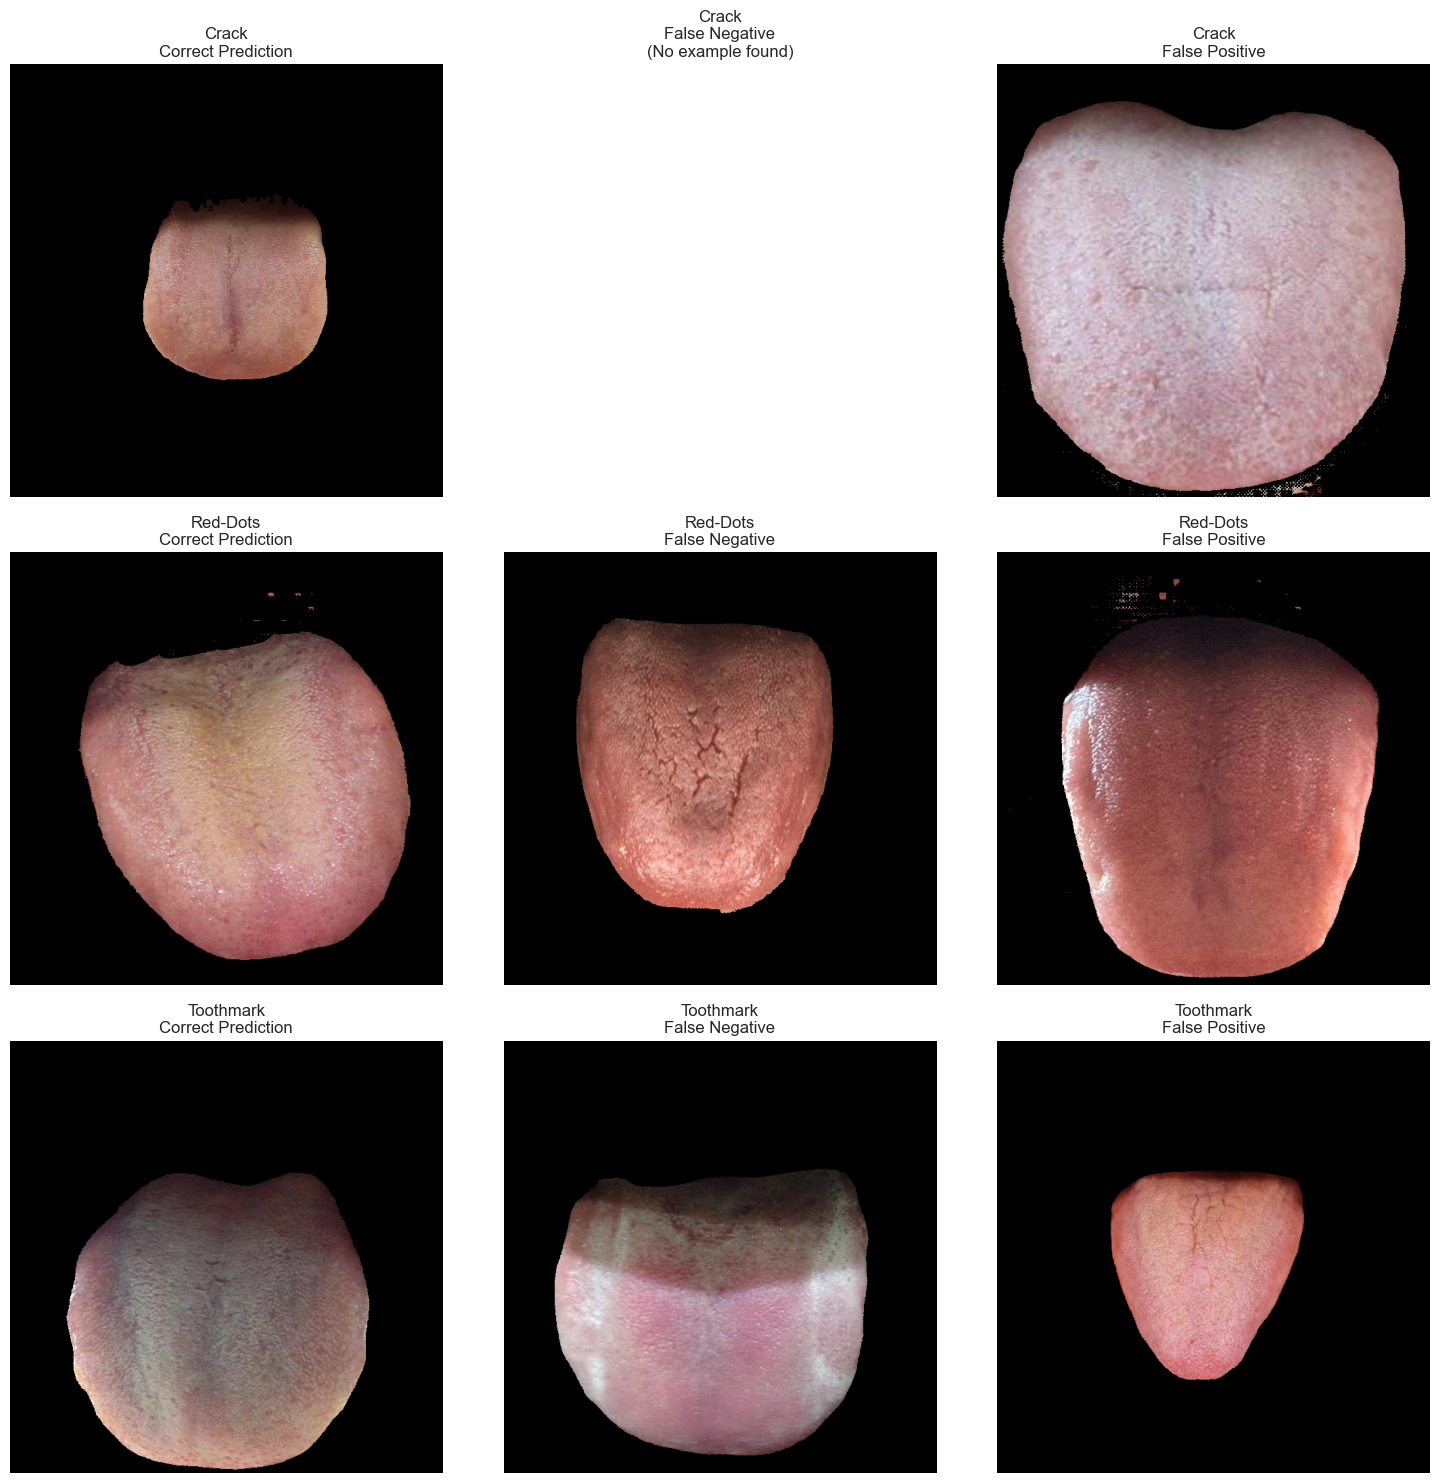

In [47]:
visualize_class_examples(dataset['test']['image'], test_labels, test_preds, class_names)